In [1]:
# standard imports
import numpy as np
import math
import scipy
import os
import csv
from tqdm import tqdm
import meshio
import matplotlib.pyplot as plt

In [2]:
# custom class imports
from node import node
from cell import cell
from mesh import exp_mesh
from fluid_problem import isentropic_fluid_problem

# utility functions
from utilities import *

# Setting Problem

In [3]:
# read su2 mesh file
meshio_mesh = meshio.read("./lam_cyl_comp_air/mesh_cylinder_quad.su2",file_format="su2")
# define mid point for rotational symmetric mesh
mid_point = np.array([0.5,0]) 
# convert mesh into custom class exp_mesh
c_mesh = exp_mesh(meshio_mesh,mid_point)

    Surface tag  cylinder will be replaced by 1
    Surface tag  farfield will be replaced by 2
-----------------------Custom mesh initialization started-----------------------
------------Shifted and Cylinder coordinates calculated and stored!-------------
-------------------Cell volumes computed in cell structures!--------------------
-------------------Cell centers computed in cell structures!--------------------
----------------------------Node neighbors assigned!----------------------------
----------------------Nodal volume participation computed!----------------------
---------------------Custom mesh initialized successfully!----------------------


# Loading Filedata

In [4]:
# reading file data
data_dir="./lam_cyl_comp_air/restart/"
data_dict = get_flow_data(data_dir,1000,1,180)

100%|██████████| 180/180 [00:22<00:00,  7.86it/s]


# Data Preparation

In [5]:
# configure state data 
q = np.vstack([data_dict["u"],data_dict["v"],data_dict["a"]])
q_avg = np.mean(q,1)
q_fluc = q - np.repeat(np.expand_dims(q_avg,1),q.shape[1],axis=1)

# Plotting sample Stencil

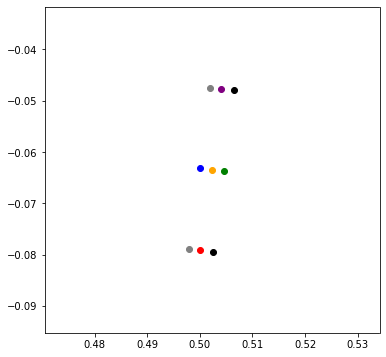

In [6]:
sample = 793
fig,ax = plt.subplots(1,1,figsize=(6,6))

u = c_mesh.nodes[sample].u
b = c_mesh.nodes[sample].b
r = c_mesh.nodes[sample].r
l = c_mesh.nodes[sample].l

if u!=None:
    u_r = c_mesh.nodes[u].r
    u_l = c_mesh.nodes[u].l
    plt.scatter(c_mesh.nodes[u].x,c_mesh.nodes[u].y,c='g')
    plt.scatter(c_mesh.nodes[u_r].x,c_mesh.nodes[u_r].y,c='black')
    plt.scatter(c_mesh.nodes[u_l].x,c_mesh.nodes[u_l].y,c='black')

if b!=None:
    b_r = c_mesh.nodes[b].r
    b_l = c_mesh.nodes[b].l
    plt.scatter(c_mesh.nodes[b].x,c_mesh.nodes[b].y,c='b')
    plt.scatter(c_mesh.nodes[b_r].x,c_mesh.nodes[b_r].y,c='grey')
    plt.scatter(c_mesh.nodes[b_l].x,c_mesh.nodes[b_l].y,c='grey')


plt.scatter(c_mesh.nodes[r].x,c_mesh.nodes[r].y,c='r')
plt.scatter(c_mesh.nodes[l].x,c_mesh.nodes[l].y,c='purple')
plt.scatter(c_mesh.nodes[sample].x,c_mesh.nodes[sample].y,c='orange')

dist = np.sqrt((c_mesh.nodes[sample].x - c_mesh.nodes[r].x)**2 + (c_mesh.nodes[sample].y - c_mesh.nodes[r].y)**2)
span = 2 * dist

xlim = [c_mesh.nodes[sample].x-span,c_mesh.nodes[sample].x+span]
ylim = [c_mesh.nodes[sample].y-span,c_mesh.nodes[sample].y+span]
ax.set_xlim(xlim)
ax.set_ylim(ylim);

# Stencil based Derivatives

In [18]:
sample_data = q_fluc[:,0]

n = c_mesh.n
N = c_mesh.N

# set temporary data structures
u_tmp,v_tmp,a_tmp = np.empty(n),np.empty(n),np.empty(n)  
u_tmp,v_tmp,a_tmp = sample_data[:n],sample_data[n:2*n],sample_data[2*n:3*n]

# component to bes examined
ex = u_tmp

# compute spatial derivatives
[dx,dy,ddx,ddy] = c_mesh.compute_finite_spatial_derivatives(ex,second=True)

# set neighbor nodes
i = sample
u = c_mesh.nodes[sample].u
b = c_mesh.nodes[sample].b
r = c_mesh.nodes[sample].r
l = c_mesh.nodes[sample].l

# set data from neighbor nodes
if u!=None:
    data_u = ex[u]

if b!=None:
    data_b = ex[b]

data_i = ex[sample]
data_r = ex[r]
data_l = ex[l]

In [8]:
## GEOMETRIC INFORMATION OF NODES

print_string = "Data Component"
print_padded(print_string)
if u!=None and b!=None:
    print("u:{} \nl:{}\ni:{}\nr:{}\nb:{}".format(data_u,data_l,data_i,data_r,data_b))
elif u!=None:
    print("u:{} \nl:{}\ni:{}\nr:{}".format(data_u,data_l,data_i,data_r))
elif b!=None:
    print("l:{}\ni:{}\nr:{}\nb:{}".format(data_l,data_i,data_r,data_b))

print(" ")

print_string = "Cartesian Coordinates (x,y)"
print_padded(print_string)

coords_i = [c_mesh.nodes[sample].x,c_mesh.nodes[sample].y]
coords_r = [c_mesh.nodes[r].x,c_mesh.nodes[r].y]
coords_l = [c_mesh.nodes[l].x,c_mesh.nodes[l].y]
if u!=None and b!=None:
    coords_u = [c_mesh.nodes[u].x,c_mesh.nodes[u].y]
    coords_b = [c_mesh.nodes[b].x,c_mesh.nodes[b].y]
    print("u:{} \nl:{}\ni:{}\nr:{}\nb:{}".format(coords_u,coords_l,coords_i,coords_r,coords_b))
elif u!=None:
    coords_u = [c_mesh.nodes[u].x,c_mesh.nodes[u].y]
    print("u:{} \nl:{}\ni:{}\nr:{}".format(coords_u,coords_l,coords_i,coords_r))
elif b!=None:
    coords_b = [c_mesh.nodes[b].x,c_mesh.nodes[b].y]
    print("l:{}\ni:{}\nr:{}\nb:{}".format(coords_l,coords_i,coords_r,coords_b))

print(" ")

print_string = "Cylinder Coordinates (r,phi)"
print_padded(print_string)

coords_cyl_i = [c_mesh.nodes[sample].rad,c_mesh.nodes[sample].theta]
coords_cyl_r = [c_mesh.nodes[r].rad,c_mesh.nodes[r].theta]
coords_cyl_l = [c_mesh.nodes[l].rad,c_mesh.nodes[l].theta]
if u!=None and b!=None:
    coords_cyl_u = [c_mesh.nodes[u].rad,c_mesh.nodes[u].theta]
    coords_cyl_b = [c_mesh.nodes[b].rad,c_mesh.nodes[b].theta]
    print("u:{} \nl:{}\ni:{}\nr:{}\nb:{}".format(coords_cyl_u,coords_cyl_l,coords_cyl_i,coords_cyl_r,coords_cyl_b))
elif u!=None:
    coords_cyl_u = [c_mesh.nodes[u].rad,c_mesh.nodes[u].theta]
    print("u:{} \nl:{}\ni:{}\nr:{}".format(coords_cyl_u,coords_cyl_l,coords_cyl_i,coords_cyl_r))
elif b!=None:
    coords_cyl_b = [c_mesh.nodes[b].rad,c_mesh.nodes[b].theta]
    print("l:{}\ni:{}\nr:{}\nb:{}".format(coords_cyl_l,coords_cyl_i,coords_cyl_r,coords_cyl_b))
print(" ")

### COMPUTING PARTIAL DERIVATIVES 
# TRANSFORM DERIVATIVES
print_string = "Transform Derivatives"
print_padded(print_string)

drdx = coords_i[0]/coords_cyl_i[0]
drdy = coords_i[1]/coords_cyl_i[0]
dphidx = - coords_i[1]/(coords_cyl_i[0]**2)
dphidy = coords_i[0]/(coords_cyl_i[0]**2)
ddrdx = (coords_i[1]**2)/(coords_cyl_i[0]**3)
ddrdy = (coords_i[0]**2)/(coords_cyl_i[0]**3)
ddphidx = (2*coords_i[1]*coords_i[0])/(coords_cyl_i[0]**4)
ddphidy = - (2*coords_i[1]*coords_i[0])/(coords_cyl_i[0]**4)

print("drdx:{}\ndrdy:{}\ndphidx:{}\ndphidy:{}\nddrdx:{}\nddrdy:{}\nddphidx:{}\nddphidy:{}\n".format(drdx,drdy,dphidx,dphidy,ddrdx,ddrdy,ddphidx,ddphidy))

# FINITE DIFFERENCE
print_string = "Finite Difference"
print_padded(print_string)

print("Coordinate: PHI")
if r!=None:
    back_phi = (data_i-data_r)/(coords_cyl_i[1]-coords_cyl_r[1])
    print("Backward:{}".format(back_phi))
if l!=None: 
    forw_phi = (data_l-data_i)/(coords_cyl_l[1]-coords_cyl_i[1])
    print("Forward:{}".format(forw_phi))
if r!=None and l!=None:
    cent_phi = (data_l-data_r)/(coords_cyl_l[1]-coords_cyl_r[1])
    print("Central:{}".format(cent_phi))
    
    cent_sec_phi = (data_u*(coords_cyl_i[1]-coords_cyl_r[1])+data_r*(coords_cyl_l[1]-coords_cyl_i[1])-data_i*(coords_cyl_l[1]-coords_cyl_r[1]))/((coords_cyl_l[1]-coords_cyl_i[1])**2*(coords_cyl_i[1]-coords_cyl_r[1]))
    print("Second Central:{}".format(cent_sec_phi))

print(" ")
print("Coordinate: RADIUS")
if b!=None:
    back_rad = (data_i-data_b)/(coords_cyl_i[0]-coords_cyl_b[0])
    print("Backward:{}".format(back_rad))
if u!=None:
    forw_rad = (data_u-data_i)/(coords_cyl_u[0]-coords_cyl_i[0])
    print("Forward:{}".format(forw_rad))
if u!=None and b!=None:
    cent_rad = (data_u-data_b)/(coords_cyl_u[0]-coords_cyl_b[0])
    print("Central:{}".format(cent_rad))

    cent_sec_rad = (data_u*(coords_cyl_i[0]-coords_cyl_b[0])+data_b*(coords_cyl_u[0]-coords_cyl_i[0])-data_i*(coords_cyl_u[0]-coords_cyl_b[0]))/((coords_cyl_u[0]-coords_cyl_i[0])**2*(coords_cyl_i[0]-coords_cyl_b[0]))
    print("Second Central:{}".format(cent_sec_rad))

print(" ")
print("Coordinate: X")
if b!=None:
    back_dx_fd = back_phi * dphidx + back_rad * drdx
    print("Backward:{}".format(back_dx_fd))
if u!=None:
    forw_dx_fd = forw_phi * dphidx + forw_rad * drdx
    print("Forward:{}".format(forw_dx_fd))
if u!=None and b!=None:
    cent_dx_fd = cent_phi * dphidx + cent_rad * drdx
    print("Central:{}".format(cent_dx_fd))

    ddx_fd = cent_sec_phi * ddphidx + cent_sec_rad * ddrdx + 2*cent_phi*dphidx*cent_rad*drdx
    print("Second:{}".format(ddx_fd))

print(" ")
print("Coordinate: Y")
if b!=None:
    back_dy_fd = back_phi * dphidy + back_rad * drdy
    print("Backward:{}".format(back_dy_fd))
if u!=None:
    forw_dy_fd = forw_phi * dphidy + forw_rad * drdy
    print("Forward:{}".format(forw_dy_fd))
if u!=None and b!=None:
    cent_dy_fd = cent_phi * dphidy + cent_rad * drdy
    print("Central:{}".format(cent_dy_fd))
    
    ddy_fd = cent_sec_phi * ddphidy + cent_sec_rad * ddrdy + 2*cent_phi*dphidy*cent_rad*drdy
    print("Second:{}".format(ddy_fd))

print(" ")
# POLYNOMIAL APPROXIMATION DERIVATIVES
print_string = "POLYNOMIAL APPROXIMATION"
print_padded(print_string)

a_phi = (data_l-data_r)/(coords_cyl_i[1]-coords_cyl_r[1])-(data_i-data_r)/(coords_cyl_l[1]-coords_cyl_r[1])
b_phi = (data_i-data_r)/(coords_cyl_i[1]-coords_cyl_r[1])-(data_l-data_r)+(data_i-data_r)*(coords_cyl_i[1]-coords_cyl_r[1])/(coords_cyl_l[1]-coords_cyl_r[1])
c_phi = data_r
dpol_phi = 2*a_phi*(coords_cyl_i[1]-coords_cyl_r[1]) + b_phi
ddpol_phi = a_phi

print("Coordinate: PHI")
print("Polynomial:{}x²+{}x+{}\nDerivative:{}\nSecond Derivative:{}\n".format(a_phi,b_phi,c_phi,dpol_phi,ddpol_phi))

if u!=None and b!=None:
    print("Coordinate: RADIUS")
    a_rad = (data_u-data_b)/(coords_cyl_i[0]-coords_cyl_b[0])-(data_i-data_b)/(coords_cyl_u[0]-coords_cyl_b[0])
    b_rad = (data_i-data_b)/(coords_cyl_i[0]-coords_cyl_b[0])-(data_l-data_b)+(data_i-data_b)*(coords_cyl_i[0]-coords_cyl_b[0])/(coords_cyl_u[0]-coords_cyl_b[0])
    c_rad = data_r
    dpol_rad = 2*a_rad*(coords_cyl_i[0]-coords_cyl_b[0]) + b_rad
    ddpol_rad = a_rad
    
    print("Polynomial:{}x²+{}x+{}\nDerivative:{}\nSecond Derivative:{}".format(a_rad,b_rad,c_rad,dpol_rad,ddpol_rad))
    
    print(" ")

    print("Coordinate: X")
    dx_pol = dpol_phi * dphidx + dpol_rad * drdx
    ddx_pol = ddpol_phi * ddphidx + ddpol_rad * ddrdx + 2*dpol_phi*dphidx*dpol_rad*drdx
    print("First:{}\nSecond:{}".format(dx_pol,ddx_pol))
    
    print(" ")
    
    print("Coordinate: Y")
    dy_pol = dpol_phi * dphidy + dpol_rad * drdy
    ddy_pol = ddpol_phi * ddphidy + ddpol_rad * ddrdy + 2*dpol_phi*dphidy*dpol_rad*drdy
    print("First:{}\nSecond:{}".format(dy_pol,ddy_pol))

---------------------------------Data Component---------------------------------
u:0.22138624639774196 
l:-0.14854116861033573
i:-0.3235265450590151
r:-0.07783053526437475
b:-0.2935082315376947
 
--------------------------Cartesian Coordinates (x,y)---------------------------
u:[0.5046651660579189, -0.06375403675149878] 
l:[0.5040705705079751, -0.04764869779142224]
i:[0.502325160343305, -0.06345842528401129]
r:[0.500084015891828, -0.07920552697227352]
b:[0.500115459836509, -0.06317927519243569]
 
--------------------------Cylinder Coordinates (r,phi)--------------------------
u:[0.508676230066, 6.157521601036] 
l:[0.506317626054, 6.188937527572]
i:[0.506317626054, 6.157521601036]
r:[0.506317626054, 6.1261056745]
b:[0.504090362913, 6.157521601036]
 
-----------------------------Transform Derivatives------------------------------
drdx:0.9921147013154363
drdy:-0.12533323356442522
dphidx:0.2475387525834586
dphidy:1.9594709926405465
ddrdx:0.031024832293789082
ddrdy:1.9440199785998373
ddphid

# Flow Fields for different Derivative Methods

In [9]:
def finite_differences(mesh,data,fd=False,second=False):
    # data vector with length n
    for nod in mesh.nodes:
        
        # stencil indizes
        i = nod.index
        r = nod.get_r()
        l = nod.get_l()
        u = nod.get_u() if nod.get_u() else None  # special boundary case
        b = nod.get_b() if nod.get_b() else None  # special boundary case

        # transform derivatives
        drdx = nod.x/nod.rad
        dthetadx = -nod.y/(nod.rad**2)
        drdy = nod.y/nod.rad
        dthetady = nod.x/(nod.rad**2)     
        if second:
            ddthetadx = (2*nod.y*nod.x)/(np.power(nod.rad,4))
            ddrdx = (nod.y*nod.y)/(np.power(nod.rad,3))
            ddthetady = -(2*nod.y*nod.x)/(np.power(nod.rad,4))
            ddrdy = (nod.x*nod.x)/(np.power(nod.rad,3))
        # compute cylindrical derivatives
        rad_u = mesh.nodes[u].rad if (u) else None
        rad_b = mesh.nodes[b].rad if (b) else None
        theta_l = mesh.nodes[l].theta if (mesh.nodes[l].theta!=0) else 2*np.pi
        theta_r = mesh.nodes[r].theta if (mesh.nodes[i].theta!=0) else mesh.nodes[r].theta-2*np.pi
        if not (u) or not (b):
            dr = 0
            dtheta = 0
        else:
            if fd:
                dr = (data[u]-data[i])/(rad_u-nod.rad)
                dtheta = (data[l]-data[i])/(theta_l-nod.theta)
            else:
                dr = (data[u]-data[b])/(rad_u-rad_b)
                dtheta = (data[l]-data[r])/(theta_l-theta_r)

        # transform to cartesian coordinates
        nod.dx = dtheta*dthetadx + dr*drdx
        nod.dy = dtheta*dthetady + dr*drdy

        if second:
            if not (u) or not (b):
                ddr = 0
                ddtheta = 0
            else:
                ddtheta = (data[l]-2*data[i]+data[r])/((theta_l-nod.theta)*(nod.theta-theta_r)) 
                ddr = (data[u]*(nod.rad-rad_b)+data[b]*(rad_u-nod.rad)-data[i]*(rad_u-rad_b))/((rad_u-nod.rad)**2*(nod.rad-rad_b))
            nod.ddx = ddtheta*ddthetadx+ddr*ddrdx
            nod.ddy = ddtheta*ddthetady+ddr*ddrdy


In [10]:
def polynomial_derivatives(mesh,data,second=False):
    # data vector with length n
    for nod in mesh.nodes:
        
        # stencil indizes
        i = nod.index
        r = nod.get_r()
        l = nod.get_l()
        u = nod.get_u() if nod.get_u() else None  # special boundary case
        b = nod.get_b() if nod.get_b() else None  # special boundary case  

        # transform derivatives
        drdx = nod.x/nod.rad
        dthetadx = -nod.y/(nod.rad**2)
        drdy = nod.y/nod.rad
        dthetady = nod.x/(nod.rad**2)    

        if second:
            ddthetadx = (2*nod.y*nod.x)/(np.power(nod.rad,4))
            ddrdx = (nod.y*nod.y)/(np.power(nod.rad,3))
            ddthetady = -(2*nod.y*nod.x)/(np.power(nod.rad,4))
            ddrdy = (nod.x*nod.x)/(np.power(nod.rad,3))
        
        if not (u) or not (b):
            nod.dx = 0
            node.ddx = 0
            nod.dy = 0
            nod.ddy = 0
        else:
            # polynomial fitting
            a_phi = (data[l]-data[r])/(nod.theta-mesh.nodes[r].theta)-(data[i]-data[r])/(mesh.nodes[l].theta-mesh.nodes[r].theta)
            b_phi = (data[i]-data[r])/(nod.theta-mesh.nodes[r].theta)-(data[l]-data[r])+(data[i]-data[r])*(nod.theta-mesh.nodes[r].theta)/(mesh.nodes[l].theta-mesh.nodes[r].theta)
            c_phi = data[r]
            dpol_phi = 2*a_phi*(nod.theta-mesh.nodes[r].theta) + b_phi
            ddpol_phi = a_phi
    
            a_rad = (data[u]-data[b])/(nod.rad-mesh.nodes[b].rad)-(data[i]-data[b])/(mesh.nodes[u].rad-mesh.nodes[b].rad)
            b_rad = (data[i]-data[b])/(nod.rad-mesh.nodes[b].rad)-(data[l]-data[b])+(data[i]-data[b])*(nod.rad-mesh.nodes[b].rad)/(mesh.nodes[u].rad-mesh.nodes[b].rad)
            c_rad = data[r]
            dpol_rad = 2*a_rad*(nod.rad-mesh.nodes[b].rad) + b_rad
            ddpol_rad = a_rad
            
            # transform to cartesian coordinates
            nod.dx = dpol_phi*dthetadx + dpol_rad*drdx
            nod.dy = dpol_phi*dthetady + dpol_rad*drdy
            if second:
                nod.ddx = ddpol_phi*ddthetadx+ddpol_rad*ddrdx+2*dpol_rad*drdx*dpol_phi*dthetadx
                nod.ddy = ddpol_phi*ddthetady+ddpol_rad*ddrdy+2*dpol_phi*dthetady*dpol_rad*drdy

In [11]:
def bilinear_derivatives(mesh,data,second=False):
    for cel in mesh.cells:

        # retrieve cartesian coordinates of cell nodes
        x = mesh.points[cel.nodes][:,0]
        y = mesh.points[cel.nodes][:,1]

        # construct condition matrix
        A = np.array([[x[0]*y[0],x[0],y[0],1],[x[1]*y[1],x[1],y[1],1],
                    [x[2]*y[2],x[2],y[2],1],[x[3]*y[3],x[3],y[3],1]])

        # compute inverse of A
        AI = np.linalg.inv(A)

        c = np.matmul(AI,data[cel.nodes])
        cel.int_coeffs = c

        cel.dx = c[0] * cel.center[1] + c[1]
        cel.dy = c[0] * cel.center[0] + c[2]        

In [12]:
# gradient field for finite difference method
finite_differences(c_mesh,u_tmp,fd=True,second=True)
dx_fd = np.empty(n) 
dy_fd = np.empty(n)
ddx_fd = np.empty(n) 
ddy_fd = np.empty(n)
for nod in c_mesh.nodes:
    dx_fd[nod.index] = nod.dx
    dy_fd[nod.index] = nod.dy
    ddx_fd[nod.index] = nod.ddx
    ddy_fd[nod.index] = nod.ddy

In [13]:
# gradient field for polynomial fitting method
polynomial_derivatives(c_mesh,u_tmp,second=True)
dx_pf = np.empty(n) 
dy_pf = np.empty(n)
ddx_pf = np.empty(n) 
ddy_pf = np.empty(n)
for nod in c_mesh.nodes:
    dx_pf[nod.index] = nod.dx
    dy_pf[nod.index] = nod.dy
    ddx_pf[nod.index] = nod.ddx
    ddy_pf[nod.index] = nod.ddy

In [14]:
# gradient field for bilinear mapping method
bilinear_derivatives(c_mesh,u_tmp)
dx_bm = np.empty(N) 
dy_bm = np.empty(N)
for cel in c_mesh.cells:
    dx_bm[cel.index] = cel.dx
    dy_bm[cel.index] = cel.dy

In [15]:
x = [nod.x for nod in c_mesh.nodes]
y = [nod.y for nod in c_mesh.nodes]
x_cell = [cel.center[0] for cel in c_mesh.cells]
y_cell = [cel.center[1] for cel in c_mesh.cells]

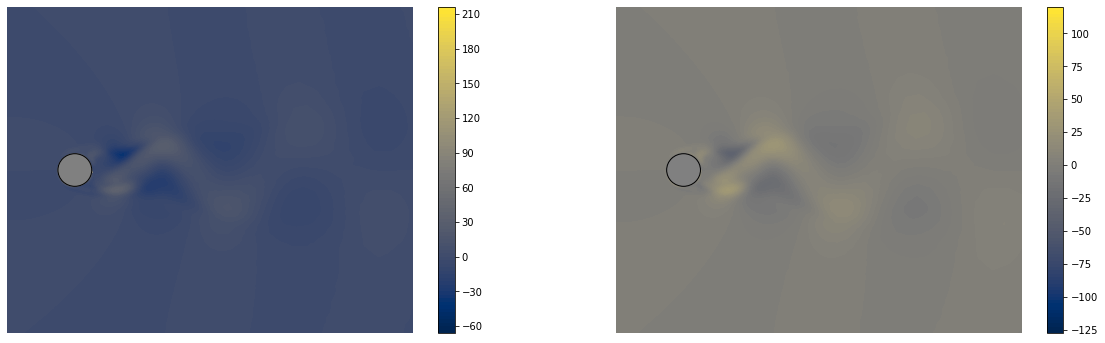

In [16]:
fig,ax = plt.subplots(1,2,figsize=(20,6))
plot_cylinder(x,y,dx_fd,cmap=get_cmap(False),ax=ax[0],clip=False,shifted = True)
plot_cylinder(x_cell,y_cell,dx_bm,cmap=get_cmap(False),ax=ax[1],clip=False,shifted = True)

# Anmerkung
- Warum sind die Ableitungen mit Finite Differenzen Verfahren und Polynomialer Approximation unterschiedlich?
- Ist das Verfahren der Polynomialen Approximation für die Bestimmung von ersten und zweiten Ableitungen valide?

# Antwort
Finite Differenzen sind numerische Verfahren die numerischer Stabilität unterliegen, die Abhängigkeiten für eine sinnvolle Ableitungsbestimmung unterliegen der CFL Bedingung (CFL<1). Die CFL Zahl für Zylindernahe Knoten ist verletzt da $u=31$, $\Delta t=0.001$. Der minimale Abstand für die Einhaltung der CFL Bedingung ist somit $\Delta x = u * \Delta t * C \approx 0.031$. Die Abstände in den Raumrichtungen sind am Beispielknoten 0.0023 in x-Richtung. 